In [1]:
###Библиотеки
import os
import pandas as pd
from nltk import word_tokenize

import nltk
nltk.download('punkt')

from nltk.tokenize import WordPunctTokenizer

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('russian')

import string

!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from sklearn.decomposition import LatentDirichletAllocation

!pip install pyldavis

import pyLDAvis
#import pyLDAvis.sklearn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 94.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=0ad730cc891f7c6eaf86195df200c7df5d2a144034b88130320ac828c4df6d00
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 36.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found

In [ ]:
uni_types = {"classic": ["СПбГУ news_events", "БФУ", "ТГУ tsu_news"],
             "tech": ["ТПУ", "СПбПУ", "БГТУ"],
             "med": ["СамГМУ"],
             "milit": ["ВАС"],
             "sport": ["СибСпорт", "Ун. Лесгафта"],
             "transport": ["ДВГУПС"]}


In [ ]:
def get_data():
    corpus = []
    universities = []
    type_uni = []
    dirpath = '/content/drive/MyDrive/КЛ ФПК/тексты_ВУЗы'
    for filename in os.listdir(dirpath):
        new_path = dirpath+ "/" + filename
        type_ = [k for k, v in uni_types.items() if filename in v][0]
        print(type_)
        for new_filename in os.listdir(new_path):
            if new_filename.endswith("data.txt"):
                text_path = new_path + "/" + new_filename
                with open (text_path, 'r', encoding = 'utf-8') as f:
                    text = f.read()
                    corpus.append(text)
                    universities.append(filename)
                    type_uni.append(type_)
    return corpus, universities, type_uni

In [ ]:
print(len(corpus)) # корпус текстов
len(universities) # перечень назвний университетов

In [ ]:
df = pd.DataFrame()
df["text"] = corpus
df["uni"] = universities
df["uni_type"] = type_uni

In [ ]:
df.sample(5) # несколько рандомных элементов таблицы

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,uni,uni_type
420,"Уважаемые руководители, преподаватели, сотрудн...",ВАС,milit
203,К наиболее эффективным методам лечения злокаче...,СПбПУ,tech
93,Балтийский центр нейротехнологий и искусственн...,БФУ,classic
216,В преддверии весеннего праздника 8 Марта герои...,СПбПУ,tech
188,Мы запускаем второй сезон подкаста «Переведи ...,СПбПУ,tech


Препроцессинг

In [ ]:
def preprocess_data(text):
    text = text.lower()
    text_tokens = WordPunctTokenizer().tokenize(text)
    spec_chars = string.punctuation + '\n\xa0«»\t—...'
    text_tokens = [token for token in text_tokens if
                   (token not in stopwords and token not in spec_chars and not any(char.isdigit() for char in token))]

    text_lemmatized = [morph.parse(token)[0].normal_form for token in text_tokens]

    return " ".join(text_lemmatized)

In [ ]:
df["clean_text"] = df["text"].apply(preprocess_data) #добавляем столбец в датафрейм

In [ ]:
 df.sample(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,uni,uni_type,clean_text
171,Состоялся финал турнира по волейболу 2022 год...,СПбПУ,tech,состояться финал турнир волейбол год среди сту...
362,Юристы Санкт-Петербургского университета проан...,СПбГУ news_events,classic,юрист санкт петербургский университет проанали...
153,Омар Ратеб приехал из Египта и уже пять лет ж...,СПбПУ,tech,омар ратёб приехать египет пять год жить санкт...
181,Большинство иностранных студентов Политеха ос...,СПбПУ,tech,большинство иностранный студент политех остать...
400,Военная орденов Жукова и Ленина Краснознаменна...,ВАС,milit,военный орден жуков ленин краснознамённый акад...


Векторизация

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(4,4)) # 4-граммы (если 1,4, то весь диапазон)
tfidf = tfidf_vectorizer.fit_transform(df["clean_text"].tolist())
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_top_tf_idf_words(text, tfidf_vectorizer, feature_names, top_n):
    tfidf_vector = tfidf_vectorizer.transform([text])
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    return feature_names[tfidf_vector.indices[sorted_nzs]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df["top_words"] = df["clean_text"].apply(get_top_tf_idf_words, tfidf_vectorizer = tfidf_vectorizer, feature_names = feature_names, top_n = 20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# df['top_words'] = df['clean_text'].apply(lambda x: get_top_tf_idf_words(x, tfidf_vectorizer, feature_names, 20))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.sample(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,uni,uni_type,clean_text,top_words
286,Дорогие коллеги! Поздравляю вас с профессиона...,СамГМУ,med,дорогой коллега поздравлять профессиональный п...,"[беззаветный служение человек выполнение, прин..."
243,"Термин ""Unicorn"" (единорог) уже несколько лет ...",СПбПУ,tech,термин unicorn единорог несколько год использо...,"[findly брать работа алгоритм, прежний остават..."
395,Уважаемые товарищи! Сердечно поздравляю вас с...,ВАС,milit,уважаемый товарищ сердечно поздравлять день уч...,"[база слушатель курсант кадет, слушатель курса..."
8,\nЗа свою более чем 140-летнюю историю Томский...,ТГУ tsu_news,classic,летний история томский государственный универс...,"[альма матёрый каждый герой, российский спортс..."
192,18 марта на канале «Санкт-Петербург» прошел т...,СПбПУ,tech,март канал санкт петербург пройти телемарафон ...,"[автомобилестроение система высокий среднее, р..."


LDA для 4-грамм

In [ ]:
lda = LatentDirichletAllocation(n_components=7, max_iter=10,learning_offset=10)

lda.fit(tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_offset=10, n_components=7)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):

    fig, axes = plt.subplots(7, 1, figsize=(30, 100)) # параметры отображения # 7строки по 1 столбцов
    axes = axes.flatten()
    all_features = {} # словарь для сохранения ключевых слов для тем

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь

        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


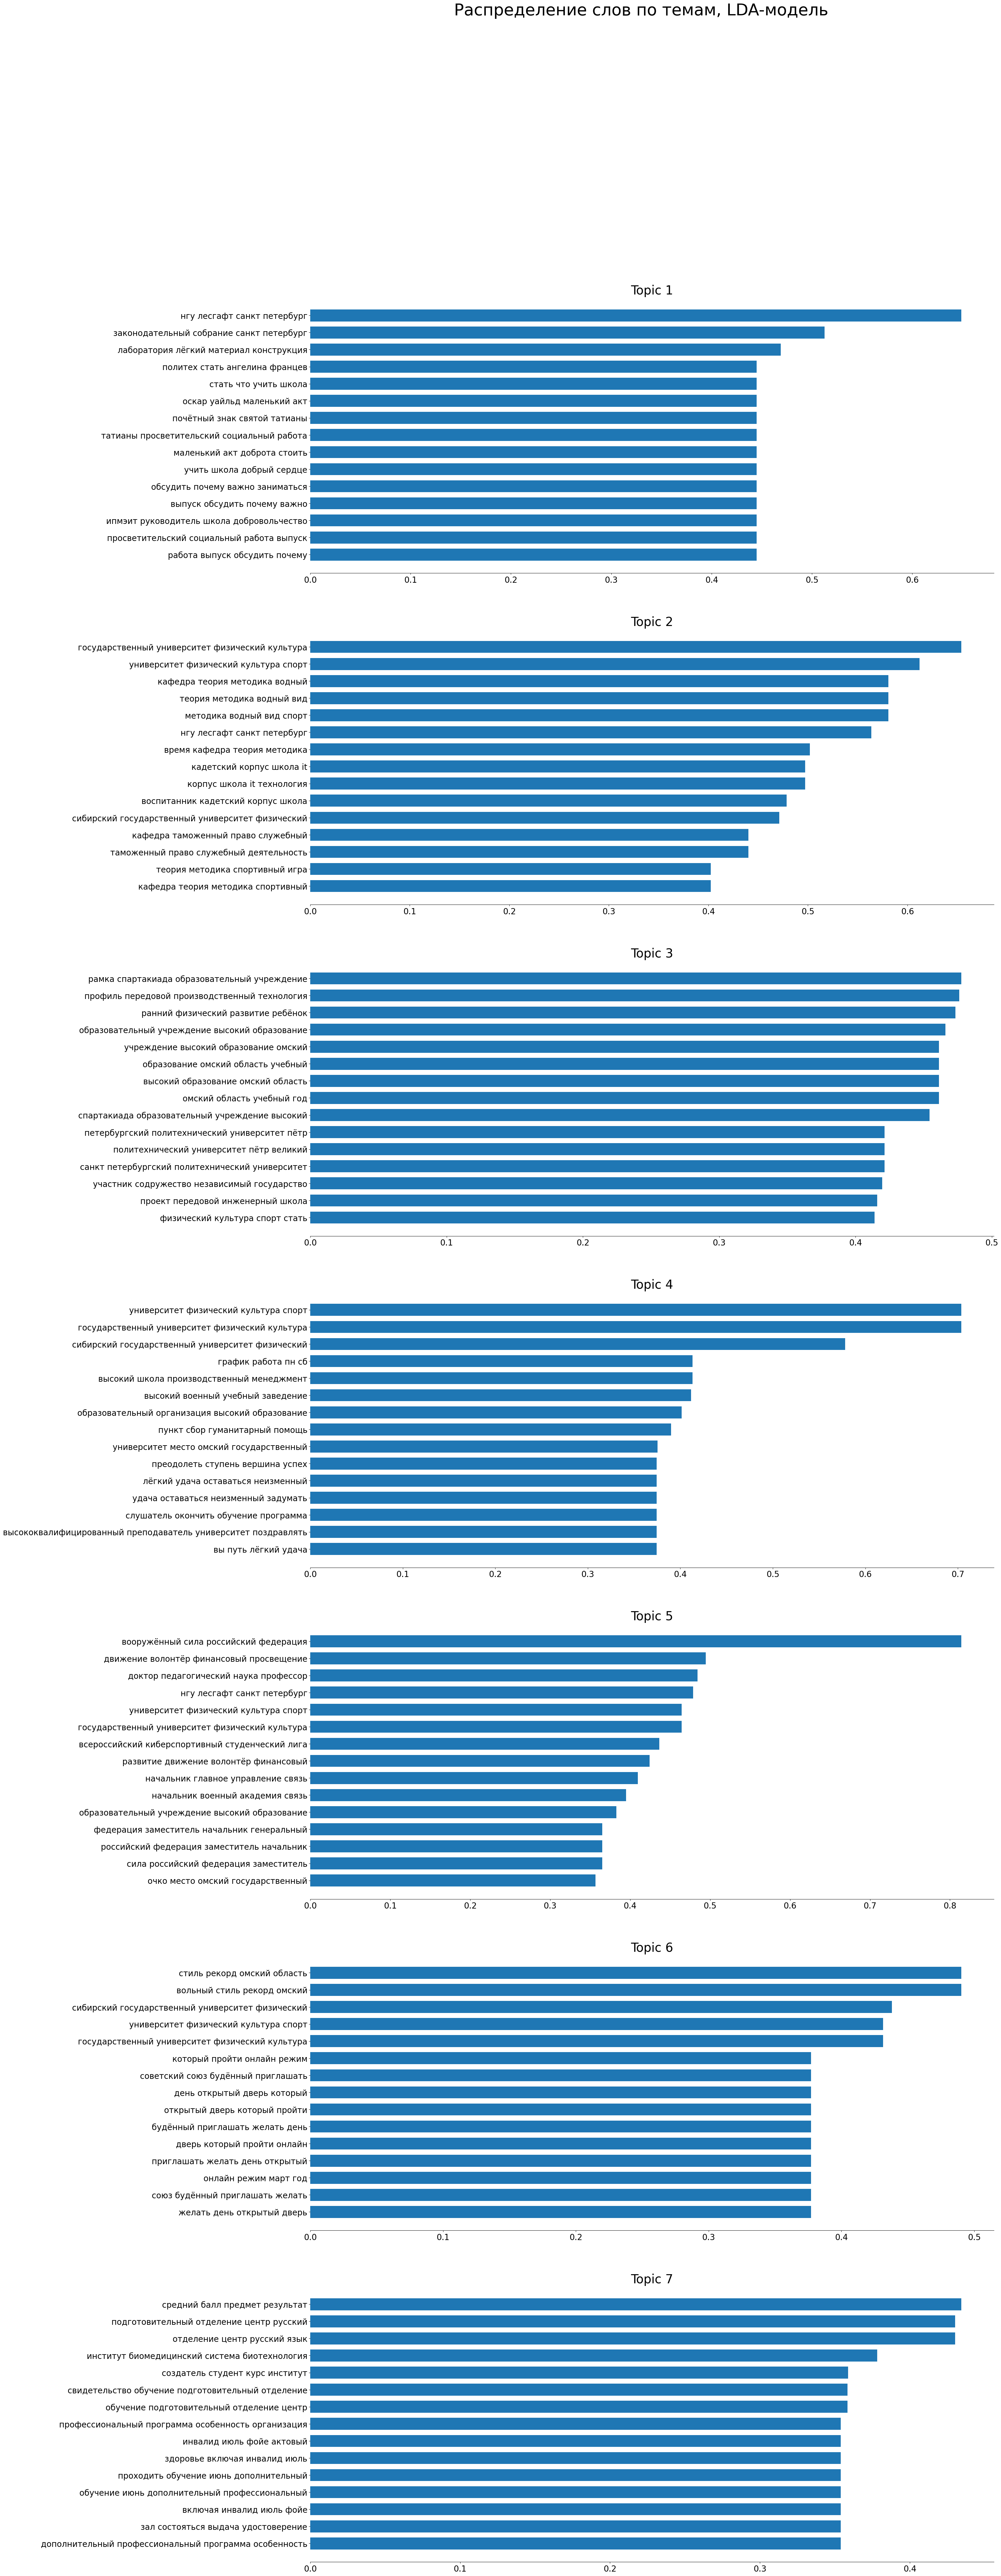

In [ ]:
tf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(lda, tf_feature_names, 15,'Распределение слов по темам, LDA-модель')